# Data Import

In this notebook we present how the data should be imported in order to be used with the automatic seismic to well tie package *wtie*. Instructions to install the package can be found in the README.md file.

In order to use the package with your own data, you must first implement small python utilities to load the data from their original format and store it into *wtie*'s internal format. Example functions can be found in the file *wtie/utils/datasets/tutorial.py*. In the following, we show how to do so step by step.

#### Load packages

In [1]:
import numpy as np
import pandas as pd
import segyio
import lasio

from pathlib import Path
from pprint import pprint

from wtie import grid, viz
from wtie.processing.logs import interpolate_nans

import matplotlib.pyplot as plt

# uncomment if your browser supports it
#%matplotlib notebook 

## Dataset
In this tutorial we work on data from the Well 159-19A of the open [Volve dataset](https://www.equinor.com/en/what-we-do/digitalisation-in-our-dna/volve-field-data-village-download.html). Data is saved in the folder **data/tutorial**.

In [2]:
# data path
folder = Path('../data/tutorial/Volve')
trajectory_path = folder / 'volve_path_15_9-19_A.txt'
table_path = folder / 'volve_checkshot_15_9_19A.txt'
logs_path = folder / 'volve_159-19A_LFP.las'
seis_path = folder / 'volve_15_9_19A_gather.sgy'

assert folder.exists()

## Data objects
The package implements a series of data objects that must be employed in order to ensure compatibility with the various methods. All classes are present in the *grid.py* file (```from wtie import grid```). Each class follows a similar logic, and must be provided with the following information:
- the *data values* (e.g. seismic or log amplitudes).
- the *data basis* (e.g. from 1.2 to 1.9s with a 0.001s sampling rate).
- the *basis type* (e.g. two-way-time or measured depth).
The different basis types supported can be found in `grid.EXISTING_BASIS_TYPES`. Units of the basis must be as writen (i.e. meters, seconds and degrees).

In [3]:
pprint(grid.EXISTING_BASIS_TYPES)

{'angle': 'Angle [°]',
 'md': 'MD (kb) [m]',
 'tlag': 'Lag [s]',
 'tvdkb': 'TVDKB [m]',
 'tvdss': 'TVDSS (MSL) [m]',
 'twt': 'TWT [s]',
 'zlag': 'Lag [m]'}


### Import well logs
We use the [lasio](https://github.com/kinverarity1/lasio) library to read the las file, read the data in a pandas [dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) and store it into the custom objects ```grid.Log``` and ```grid.LogSet```. 

In [4]:
las_logs = lasio.read(logs_path)
las_logs = las_logs.df()
las_logs.head(4)

,LFP_AI,LFP_AI_B,LFP_AI_G,LFP_AI_LOG,LFP_AI_O,LFP_AI_V,LFP_API,LFP_BADDATA,LFP_BVWE,LFP_BVWT,...,LFP_VS_LOG,LFP_VS_O,LFP_VS_V,LFP_VSH,LFP_VSHDN,LFP_VSHDRY,LFP_VSHDRYC,LFP_VSHDRYWC,LFP_VSHGR,LFP_WATER
DEPTH,,,,,,,,,,,,,,,,,,,,,
3500.0183,9772.7246,9772.7246,9386.7666,9772.1309,9559.9043,9772.7246,0.899,0.0,0.1122,0.1209,...,1939.235,1951.8311,1939.235,0.2519,0.3793,0.2431,0.2431,0.2431,0.2519,1.0
3500.1707,9738.0371,9738.0371,9332.1416,9738.1611,9511.0146,9738.0371,0.899,0.0,0.1074,0.1159,...,1917.505,1929.3831,1917.505,0.2467,0.4821,0.2382,0.2382,0.2382,0.2467,1.0
3500.3230,9682.7344,9682.7344,9184.1543,9682.8135,9395.1484,9682.7344,0.899,0.0,0.1082,0.1127,...,1907.812,1919.6980,1907.812,0.1309,0.5391,0.1263,0.1263,0.1263,0.1309,1.0
3500.4756,9518.9395,9518.9395,8973.8682,9518.5410,9204.9590,9518.9395,0.899,0.0,0.1254,0.1292,...,1919.943,1933.9720,1919.943,0.1112,0.4539,0.1073,0.1073,0.1073,0.1112,1.0


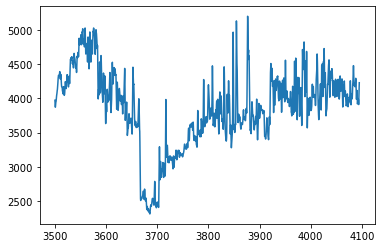

In [5]:
basis = las_logs.LFP_VP.index
vp = las_logs.LFP_VP.values

fig,ax = plt.subplots()
ax.plot(basis, vp)

The logs are recorded in *measured depth*, according to the  `grid.EXISTING_BASIS_TYPES` we therefore need to set the `basis_type` variable as `'md'`.

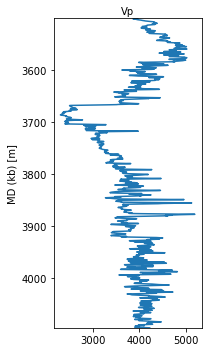

In [6]:
Vp = grid.Log(las_logs.LFP_VP.values, las_logs.LFP_VP.index, 'md', name='Vp')
viz.plot_trace(Vp);

In [7]:
def import_logs(file_path: str) -> grid.LogSet:
    file_path = Path(file_path)
    assert file_path.name == 'volve_159-19A_LFP.las'

    # Read file
    las_logs = lasio.read(file_path)
    las_logs = las_logs.df()

    # Select some logs, there are more, we only load the follwoing
    # must at least contain the keys 'Vp' for acoustic velocity
    # and 'Rho' for the bulk density. 'Vs', for shear velocity, must also
    # be imported if one whishes to perform a prestack well-tie.
    # Other logs are optional.
    log_dict = {}


    log_dict['Vp'] = grid.Log(las_logs.LFP_VP.values, las_logs.LFP_VP.index, 'md', name='Vp')
    log_dict['Vs'] = grid.Log(las_logs.LFP_VS.values, las_logs.LFP_VS.index, 'md', name='Vs')
    
    # Density contains some NaNs, I fill them with linear interpolation.
    log_dict['Rho'] = grid.Log(interpolate_nans(las_logs.LFP_RHOB.values),
                    las_logs.LFP_RHOB.index, 'md', name='Rho')

    log_dict['GR'] = grid.Log(interpolate_nans(las_logs.LFP_GR.values), las_logs.LFP_VP.index, 'md')
    log_dict['Cali'] = grid.Log(las_logs.LFP_CALI.values, las_logs.LFP_VP.index, 'md')

    return grid.LogSet(log_dict)

In [8]:
logset_md = import_logs(logs_path) # md is for measured depth
print(logset_md)

5 logs in MD (kb) [m] of length 3905.


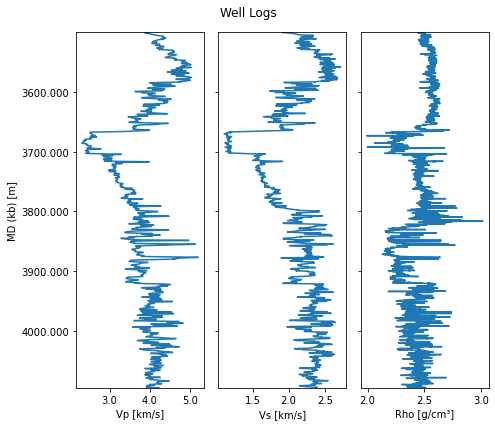

In [9]:
viz.plot_logset(logset_md);

### Import Seismic
We use the package [segyio](https://github.com/equinor/segyio) to read the segy and strore the data in the  `grid.Seismic` and `grid.PreStackSeismic` objects. The provided segy is a composite angle gather extracted along the well path.

In [10]:
with segyio.open(seis_path, 'r') as f:
    print(f.samples.size) # number of time samples
    print(f.ilines) 
    print(f.xlines)
    print(f.offsets) # these are actually angles, from 0 to 45 degrees

699
[0]
[0]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


In [11]:
def import_seismic(file_path: str) -> grid.Seismic:
    file_path = Path(file_path)
    assert file_path.name == 'volve_15_9_19A_gather.sgy'

    with segyio.open(file_path, 'r') as f:
        _twt = f.samples / 1000 # two-way-time in seconds
        _seis = np.squeeze(segyio.tools.cube(f)) # 2D (angles, samples)
        
    # stacking the first 8 angles
    _seis = np.sum(_seis[:8,:], axis=0)

    return grid.Seismic(_seis, _twt, 'twt', name='Real seismic')


def import_prestack_seismic(file_path: str) -> grid.PreStackSeismic:
    """For simplicity, only angle gathers are allowed."""
    file_path = Path(file_path)
    assert file_path.name == 'volve_15_9_19A_gather.sgy'

    with segyio.open(file_path, 'r') as f:
        _twt = f.samples / 1000
        _seis = np.squeeze(segyio.tools.cube(f))
        _angles = f.offsets

    seismic = []
    for i, theta in enumerate(_angles):
        seismic.append(grid.Seismic(_seis[i,:], _twt, 'twt', theta=theta))

    return grid.PreStackSeismic(seismic, name='Real gather')

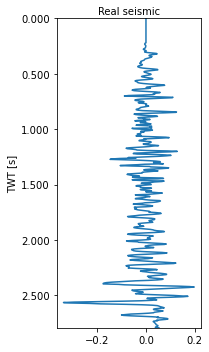

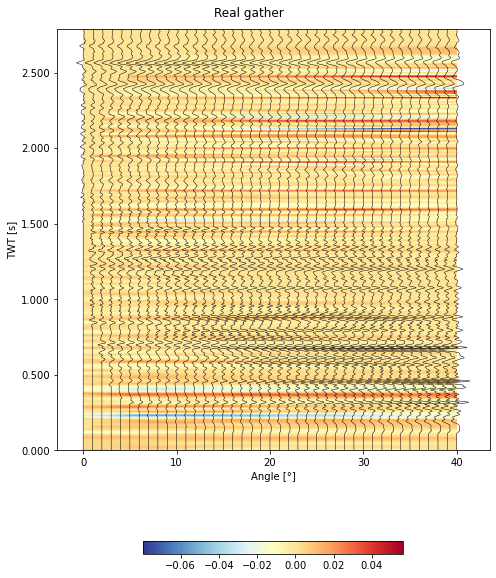

In [12]:
seismic = import_seismic(seis_path)
gather = import_prestack_seismic(seis_path)
viz.plot_trace(seismic)
viz.plot_prestack_trace_as_pixels(gather, figsize=(7,9));

### Well trajectory
We store the well trajectory in the `grid.WellPath` object.

In [13]:
print(grid.WellPath.__doc__)
print(grid.WellPath.__init__.__doc__)

Well trajectory information. To link Measured Depth to True Vertical Depth.

        Parameters
        ----------
        md : np.ndarray
            Measured depth sequence in meters.
        tvdss : np.ndarray , optional
            True vertical depth sequence in meters. Measured from sea surface /
            mean sea level. If not provided, well is assumed vertical.
        kb : float, optional
            KellyBushing height in meters.
        


In [14]:
def import_well_path(file_path: str) -> grid.WellPath:
    file_path = Path(file_path)
    assert file_path.name == 'volve_path_15_9-19_A.txt'

    _wp = pd.read_csv(file_path, header=None, delimiter=r"\s+",
                      names=('MD (kb) [m]', 'Inclination', 'Azimuth'))

    kb = 25 # meters

    _tvd = grid.WellPath.get_tvdkb_from_inclination(\
                                            _wp.loc[:,'MD (kb) [m]'].values,
                                            _wp.loc[:,'Inclination'].values[:-1]
                                                    )
    _tvd = grid.WellPath.tvdkb_to_tvdss(_tvd, kb)

    return grid.WellPath(md=_wp.loc[:,'MD (kb) [m]'].values, tvdss=_tvd, kb=kb)

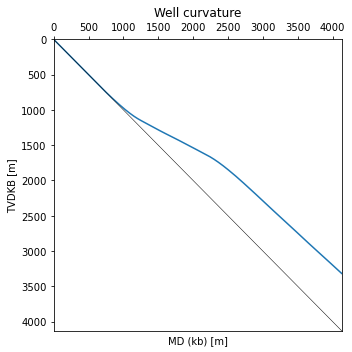

In [20]:
wellpath = import_well_path(trajectory_path)
viz.plot_wellpath(wellpath);

### Time-Depth relation table
We strore the depth-time relation table to a `grid.TimeDepthTable` object.

In [16]:
print(grid.TimeDepthTable.__doc__)
print(grid.TimeDepthTable.__init__.__doc__)

Time Depth Table. TVDSS [m] vs TWT [s].

        Parameters
        ----------
        twt : _sequence_t
            Two-way travel-time [s]
        tvdss : _sequence_t
            True vertical depth w.r.t sea surface (mean sea level)
            (corrected for well trajectory) [m]
        


In [17]:
def import_time_depth_table(file_path: str) -> grid.TimeDepthTable:
    file_path = Path(file_path)
    assert file_path.name == 'volve_checkshot_15_9_19A.txt'

    _td = pd.read_csv(file_path, header=None, delimiter=r"\s+", skiprows=[0],
                  names=('Curve Name', 'TVDBTDD', 'TVDKB', 'TVDSS', 'TWT'))

    _twt = _td.loc[:,'TWT'].values / 1000 # seconds
    _tvdss = np.abs(_td.loc[:,'TVDSS'].values) # meters

    return grid.TimeDepthTable(twt=_twt, tvdss=_tvdss)

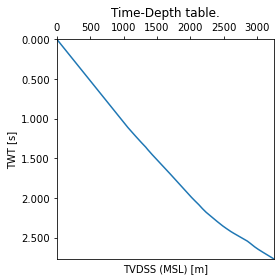

In [19]:
td_table = import_time_depth_table(table_path)
viz.plot_td_table(td_table);